In [1]:
import splitfolders
import os
import tensorflow as tf

In [ ]:
#Splits folders into training, test, validation sets at a 80/10/10 ratio for me
splitfolders.ratio("data/images", output = "image_sets",
seed = 1337, ratio=(.8, .1, .1),group_prefix=None, move=False)

#This method utilizes a specific function though, which would be useful if I were to make an all-in one class for the model, but I don't think I'm there yet.

In [32]:
#Limit tensorflow from using all the Virtual RAM in GPU
gpus = tf.config.experimental.list_physical_devices('GPU')  #Grabs all GPU available on machine
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) #Limits Memory Growth

Cleaning Up Images

In [2]:
#Images were precleaned of any corrupted files/non-jpgs that wouldn't be able to be opened, but just a sample in case I need to do this again
import cv2
import imghdr
import matplotlib.pyplot as plt

In [ ]:
data_dir = 'data/images'
image_exts = ['jpeg','jpg','bmp','png']
os.listdir(os.path.join(data_dir, 'bread'))

In [36]:
for image_class in os.listdir(data_dir):                             #Grabs 3 subfolders in images folder
    for image in os.listdir(os.path.join(data_dir, image_class)):    #Grabs every image in the subdirectories
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)                             #Tests if image can be loaded into open cv. Which is should
            tip = imghdr.what(image_path)                            #Tests if image matches one of the paths in image_extensions
            if tip not in image_exts:                                #If its not apart of it, then it removes the image from the subfolders
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
"""Nothing should change since everything is pre-cleaned."""

KeyboardInterrupt: 

In [3]:
%matplotlib notebook
"""imread should convert image into a set of arrays"""
img = cv2.imread(os.path.join(data_dir,'butt','butt_5.jpg'))
img.shape

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

NameError: name 'data_dir' is not defined

Loading Data

In [4]:
#tensorflow allows to make data pipelines. I love pipes.
import numpy as np

In [ ]:
tf.keras.utils.image_dataset_from_directory?? #checks documentation. If we wanted to reduce use of vram, can reduce batch size

In [202]:
data = tf.keras.utils.image_dataset_from_directory('data/images', class_names = ['bread','butt'])

Found 6385 files belonging to 2 classes.


In [168]:
data_iterator = data.as_numpy_iterator() #Allows looping through data pipeline
batch = data_iterator.next()  #Allows access of data pipeline itself. Not all that useful unless we have a tonne of data.

In [ ]:
len(batch)  #the 2 parts are the images and the labels

In [ ]:
#images represented by numpy arrays
#Class 1 = Dogs, Class 0 = Bread
batch[0].shape  #the keras utility configured all images to have the same consistent shape before batching them up
batch[1] #represents labels: bread or corgi

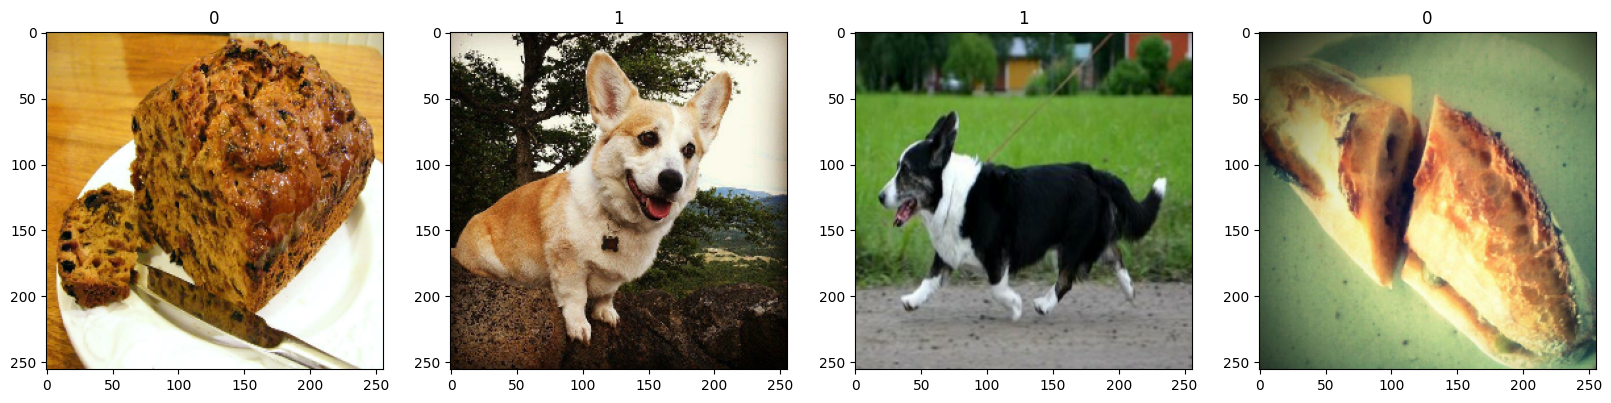

In [201]:

#Can use this visualizer to check which label represents bread of dogs. Which...isn't working.
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) #Plots an image in each column
for idx, img in enumerate(batch[0][0:4]):        #Warning: This code only grabs labels from the 0:4 position, so if the arrays grabbed are changed, there may be a mixmatch with the labels
    ax[idx].imshow(img.astype(int))              #The enumerate function just adds an index to a list.
    ax[idx].title.set_text(batch[1][idx])    

In [192]:
#Ideally, values should be as small as possible for optimization processes
#Since max value is 255 and min is 0, we can divide everything by 255 to have a range of 0-1
scaled = batch[0] /255

In [203]:
#To scale across the entire dataset and not just a batch, we want to apply the transformation
data = data.map(lambda x, y: (x/255, y))  #map applies the transformation in the pipeline. x represents images, y represents target variable or labels
scaled_iterator = data.as_numpy_iterator()

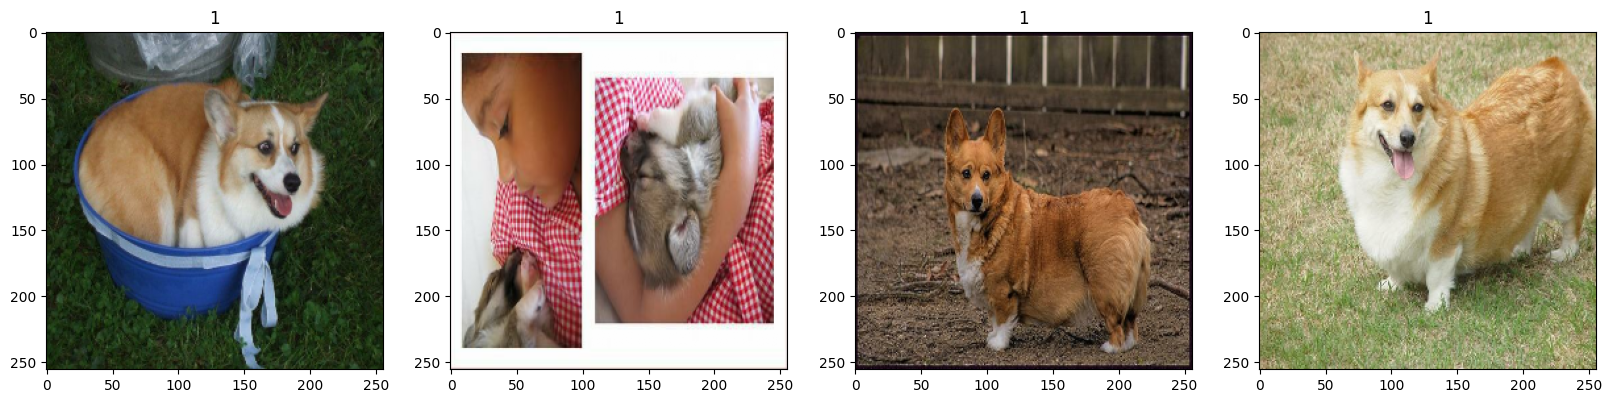

In [210]:
batch = scaled_iterator.next()
#Can keep spamming this function since batch will keep shuffling
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) 
for idx, img in enumerate(batch[0][0:4]):        
    ax[idx].imshow(img)                    #No longer an integer
    ax[idx].title.set_text(batch[1][idx])

Splitting Data

In [ ]:
len(data) #200 Batches
train_size = int(len(data)*.8)  #160 Batches
test_size = int(len(data)*.1)   #20 Batches
val_size = int(len(data)*.1)    #20 Batches

In [215]:
#tensorflow has take and skip function which can be used to generate datasets
train_set = data.take(train_size)
test_set = data.skip(train_size).take(test_size)
val_set = data.skip(train_size+test_size).take(val_size)

Model Building. "Deep" Learning CNN

In [13]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import regularizers

In [265]:
#Each Layer performs a computational transformation on the tensor. 
model = Sequential()

In [266]:
#Add in the layers
#Add convolutional layer and maxpooling layer
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
#First layer would be an input. It has 16 filters. filters are 3 pixels by 3 pixels each. stride of 1: moves 1 pixel each time. Regularizers added because of overfitting
model.add(MaxPooling2D())                                                    
#Relu Activation: Any output below zero is converted to zero, and positive values are preserved
#Max Pooling takes max value from a 2x2 pixel region from relu activation and returns that number, effectively condensing information down
model.add(Conv2D(32, (3,3), 1, activation='relu'))                           
#Same, but with more filters
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Flatten())                                                        
#Want to condense numbers of rows, and the filters create a channel value. Instead of 2 dimensions, flatten reduces the input data into a single dimension
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))                                   
#Chains together all the inputs. regularization is typically added to full connected layers, like the dense layer.
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))                                   
#Sigmoid activation: Same as relu, but using a different type of function. Result is either zero or 1 because we have a sigmoid activation

In [267]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(),metrics = ['accuracy'])  
#in this case we're using the adam optimizer since its typically the best for machine learning cases, apart from sparse data
#we want to track accuracy of model

In [268]:
model.summary()
#Shows what each layer is doing

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 16)      

Train the Model

In [269]:
logdir = 'logs'

In [270]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir) #To save model

In [283]:
hist = model.fit(train_set, epochs = 10, validation_data = val_set, callbacks=[tensorboard_callback])
#20 epochs might have been too many. Next time 10 epochs 
#In a function, it should terminate once validation error bottoms out. Food for thought

Epoch 1/10
160/160 [==============================] - 130s 807ms/step - loss: 0.1918 - accuracy: 0.9686 - val_loss: 0.2747 - val_accuracy: 0.9504
Epoch 2/10
160/160 [==============================] - 127s 789ms/step - loss: 0.1827 - accuracy: 0.9748 - val_loss: 0.2807 - val_accuracy: 0.9456
Epoch 3/10
160/160 [==============================] - 132s 821ms/step - loss: 0.1797 - accuracy: 0.9736 - val_loss: 0.3165 - val_accuracy: 0.9392
Epoch 4/10
160/160 [==============================] - 134s 835ms/step - loss: 0.2064 - accuracy: 0.9701 - val_loss: 0.4016 - val_accuracy: 0.9040
Epoch 5/10
160/160 [==============================] - 130s 812ms/step - loss: 0.1858 - accuracy: 0.9762 - val_loss: 0.2591 - val_accuracy: 0.9472
Epoch 6/10
160/160 [==============================] - 124s 771ms/step - loss: 0.1526 - accuracy: 0.9787 - val_loss: 0.3483 - val_accuracy: 0.9104
Epoch 7/10
160/160 [==============================] - 130s 807ms/step - loss: 0.1809 - accuracy: 0.9766 - val_loss: 0.3183 -

In [285]:
model.save_weights('model_weights_70.h5')
model.save('model_70.h5')
#Bit of Overfit, but can't get validation accuracy beyond 95%.

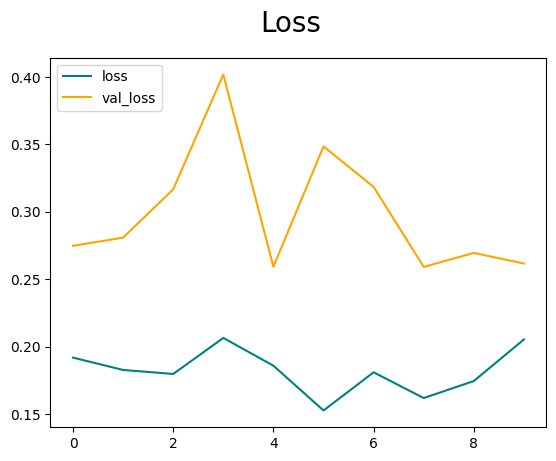

In [286]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#Why is validation loss so high. This suggests model is overfitting. Let's recreate it with less filters. Also add some regularization with l2

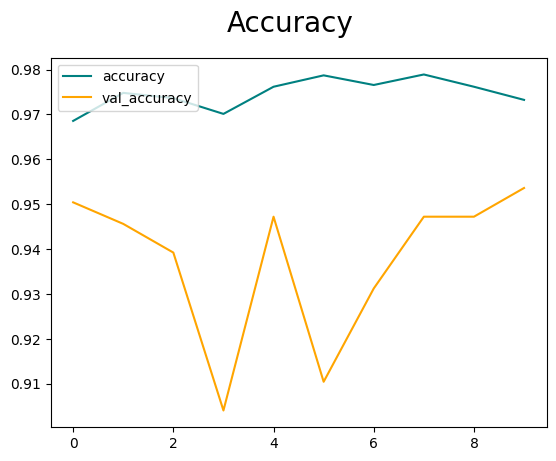

In [287]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


Evaluate Performance

In [12]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [289]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test_set.as_numpy_iterator():
    X, y = batch                       #predicting the array image, to see if label matches
    yhat = model.predict(X)          
    #yhat is predicted value
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [298]:
print(f'Precision: {pre.result()}, Recall: {re.result()}, Accuracy: {acc.result()}')

Precision: 0.9840637445449829, Recall: 0.935606062412262, Accuracy: 0.9671875238418579


Precision: 0.9840637445449829, Recall: 0.935606062412262, Accuracy: 0.9671875238418579. Overall. Not Terrible

Test on Random Images

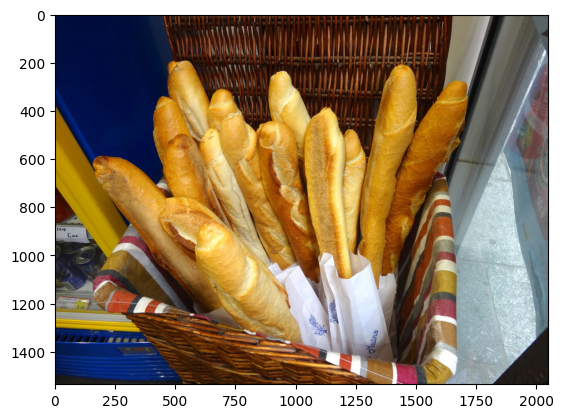

In [305]:
test_images = cv2.imread('test_images/baguette.jpg')
plt.imshow(cv2.cvtColor(test_images, cv2.COLOR_BGR2RGB))
plt.show()

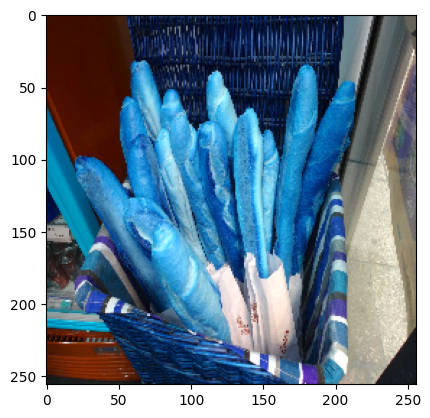

In [317]:
resize = tf.image.resize(test_images, (256,256))
plt.imshow(resize.numpy().astype(int))

In [318]:
#Store in list form
np.expand_dims(resize, 0)

array([[[[ 59.  ,  16.  ,   1.  ],
         [ 56.5 ,  15.5 ,   0.5 ],
         [ 59.  ,  16.  ,   1.  ],
         ...,
         [ 95.25,  90.75,  83.25],
         [ 97.  ,  91.  ,  84.  ],
         [ 97.75,  94.75,  86.75]],

        [[ 58.5 ,  16.5 ,   1.5 ],
         [ 59.  ,  16.  ,   1.  ],
         [ 58.  ,  15.  ,   0.  ],
         ...,
         [101.75,  98.25,  88.75],
         [100.5 ,  95.5 ,  86.5 ],
         [ 99.  ,  96.  ,  88.  ]],

        [[ 57.  ,  16.  ,   1.  ],
         [ 59.  ,  16.  ,   1.  ],
         [ 59.  ,  16.  ,   1.  ],
         ...,
         [100.  ,  97.  ,  86.  ],
         [102.5 ,  98.75,  87.  ],
         [ 99.  ,  96.  ,  88.  ]],

        ...,

        [[ 18.75,  22.75,  23.75],
         [ 20.75,  25.75,  24.75],
         [ 20.75,  26.5 ,  25.5 ],
         ...,
         [ 22.5 ,  26.25,  28.  ],
         [ 24.25,  28.25,  29.25],
         [ 21.5 ,  25.5 ,  26.5 ]],

        [[ 21.75,  26.75,  29.75],
         [ 22.  ,  27.  ,  28.  ],
         [ 2

In [319]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 93ms/step


In [320]:
yhat

array([[0.01022241]], dtype=float32)

In [322]:
if yhat[0][0] > 0.5:
    print(f'Predicted class has a {yhat[0][0]*100:.2f}% chance of being a dog')
else:
    print(f'Predicted class has a {(1 - yhat[0][0])*100:.2f}% chance of being bread')

Predicted class has a 98.98% chance of being bread


Now to turn everything into a class object

In [20]:
import keras
import cv2

In [21]:
model = keras.models.load_model('model_70.h5')

def dog_bread_classifier(img):
        test_images = cv2.imread(img)
        resize = tf.image.resize(test_images, (256,256))
        np.expand_dims(resize, 0)
        yhat = model.predict(np.expand_dims(resize/255, 0))

        if yhat[0][0] > 0.5:
            print(f'Predicted class has a {yhat[0][0]*100:.2f}% chance of being a dog')
        else:
            print(f'Predicted class has a {(1 - yhat[0][0])*100:.2f}% chance of being bread')
        return plt.imshow(cv2.cvtColor(test_images, cv2.COLOR_BGR2RGB)), img  
    


In [9]:
folder_path = "test_images"

# get a list of all files and directories in the folder
files_and_directories = os.listdir(folder_path)

file_names = [] # create an empty list to store the file names

# iterate over the files and directories
for file_or_directory in files_and_directories:
  # get the full path of the file or directory
  path = os.path.join(folder_path, file_or_directory)

  # check if the path is a file
  if os.path.isfile(path):
    # append the file name to the list
    file_names.append(os.path.join(folder_path, file_or_directory))

file_names

['test_images\\baguette.jpg',
 'test_images\\daschbun.JPG',
 'test_images\\Dog-In-A-Dog.jpg',
 'test_images\\drawn.JPG',
 'test_images\\IMG_3101.jpg',
 'test_images\\itsaloaf.jpg',
 'test_images\\snoot.JPG',
 'test_images\\toughcase.JPG',
 'test_images\\toughcase2.JPG',
 'test_images\\toughcase3.JPG']

1/1 [==============================] - 0s 43ms/step
Predicted class has a 99.54% chance of being a dog


(<matplotlib.image.AxesImage at 0x1c6e8898b50>, 'test_images\\IMG_3101.jpg')

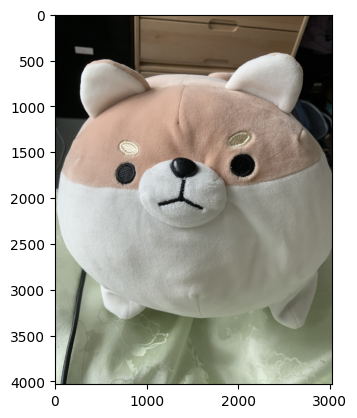

In [24]:
dog_bread_classifier(file_names[4])
#MY MODEL FAILED ME

1/1 [==============================] - 0s 36ms/step
Predicted class has a 99.80% chance of being a dog


(<matplotlib.image.AxesImage at 0x1c6f0c7cd30>, 'test_images\\toughcase2.JPG')

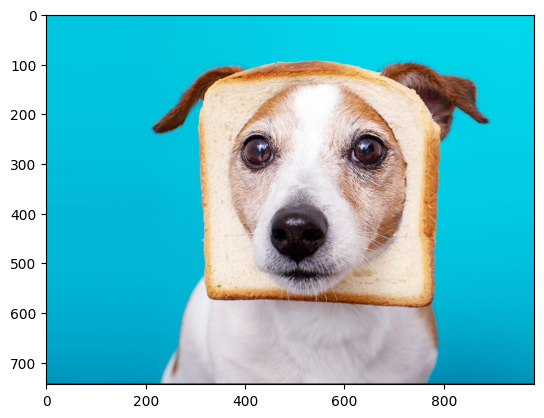

In [23]:
dog_bread_classifier(file_names[8])

1/1 [==============================] - 0s 106ms/step
Predicted class has a 75.17% chance of being bread


(<matplotlib.image.AxesImage at 0x1c6f2b05640>, 'test_images\\itsaloaf.jpg')

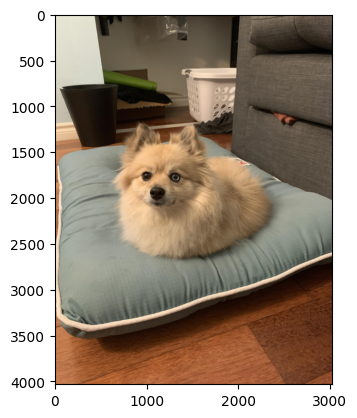

In [26]:
dog_bread_classifier(file_names[5])